In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from pathlib import Path
from torch.utils.data.dataset import Dataset
import h5py
from typing import cast

In [2]:
n_phen = 25
n_geno = 100000
n_alleles = 2
n_loci = n_geno * n_alleles
batch_size = 128
num_workers = 10

latent_space_p = 750


timestamp = 20250221

In [10]:
g_params = {
    'input_length': 200000,  # n_loci * n_alleles
    'loci_count': 100000,
    'window_size': 100,
    'latent_space_g': 2449,
    'n_out_channels': 7,
    'window_stride': 12
}

g_latent = 2449

In [11]:
file_prefix = "test_sim_WF_1kbt_10000n_5000000bp"

In [12]:

# Dataset classes
class BaseDataset(Dataset):
    def __init__(self, hdf5_path: Path) -> None:
        self.h5 = h5py.File(hdf5_path, "r")
        self._strain_group = cast(h5py.Group, self.h5["strains"])
        self.strains: list[str] = list(self._strain_group.keys())

    def __len__(self) -> int:
        return len(self._strain_group)

class GenoPhenoDataset(BaseDataset):
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        strain = self.strains[idx]
        strain_data = cast(Dataset, self._strain_group[strain])
        phens = torch.tensor(strain_data["phenotype"][:], dtype=torch.float32)
        gens = torch.tensor(strain_data["genotype"][:], dtype=torch.float32).flatten()
        return phens, gens

# Create datasets and loaders
test_data_gp = GenoPhenoDataset(f'../gpatlas_input/'+file_prefix+'_test.hdf5')

test_loader_gp = torch.utils.data.DataLoader(
    dataset=test_data_gp,
    batch_size=batch_size,  # You'll need to define batch_size
    num_workers=num_workers,  # You'll need to define num_workers
    shuffle=False  # Keep False for evaluation
)

In [13]:

class P_net(nn.Module):
    def __init__(self, phen_dim=None, N=None):
        if phen_dim is None:
            phen_dim = n_phen

        out_phen_dim = n_phen
        latent_dim = N
        batchnorm_momentum = 0.8

        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=out_phen_dim),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

class GQ_to_P_net(nn.Module):
    def __init__(self, N, latent_space_g):
        super().__init__()

        batchnorm_momentum = 0.8
        g_latent_dim = latent_space_g
        latent_dim = N
        self.encoder = nn.Sequential(
            nn.Linear(in_features=g_latent_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=latent_dim),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


In [14]:

class LDEncoder(nn.Module):
    def __init__(self, input_length, loci_count, window_size, latent_dim, n_out_channels, window_stride=5):
        super().__init__()

        self.input_length = input_length
        self.loci_count = loci_count
        self.window_size = window_size
        self.latent_dim = latent_dim
        self.n_out_channels = n_out_channels
        self.n_groups = loci_count // window_size

        # Encoder layers
        self.encoder_conv = nn.Conv1d(
            in_channels=self.n_groups,
            out_channels=self.n_groups * n_out_channels,
            kernel_size=window_size * 2,
            stride=window_stride,
            groups=self.n_groups,
            bias=True
        )

        self.encoder_act = nn.LeakyReLU(0.1)

        self.encoder_fc = nn.Linear(self.n_groups * n_out_channels, latent_dim)
        self.encoder_fc_act = nn.LeakyReLU(0.1)

    def forward(self, x):
        """Forward pass through the encoder"""
        batch_size = x.size(0)

        # Reshape to group by windows
        x = x.reshape(batch_size, self.n_groups, self.window_size * 2)

        # Apply convolution
        x = self.encoder_conv(x)
        x = self.encoder_act(x)

        # Flatten and map to latent space
        x = x.reshape(batch_size, self.n_groups * self.n_out_channels)
        x = self.encoder_fc(x)
        return self.encoder_fc_act(x)

# Load the saved encoder
def load_pretrained_encoder(encoder_path, params):
    encoder = LDEncoder(
        input_length=params['input_length'],
        loci_count=params['loci_count'],
        window_size=params['window_size'],
        latent_dim=params['latent_space_g'],
        n_out_channels=params['n_out_channels'],
        window_stride=params.get('window_stride', 5)
    )

    # Load state dict
    state_dict = torch.load(encoder_path)
    encoder.load_state_dict(state_dict)

    return encoder

#GQ = load_pretrained_encoder("localgg/localgg_enc_1kbt_V1_state_dict.pt", g_params)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/tmp/ipykernel_583898/4161418665.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(encoder_path)
/tmp/ipykernel_583898/4161418665.py:28: FutureWar

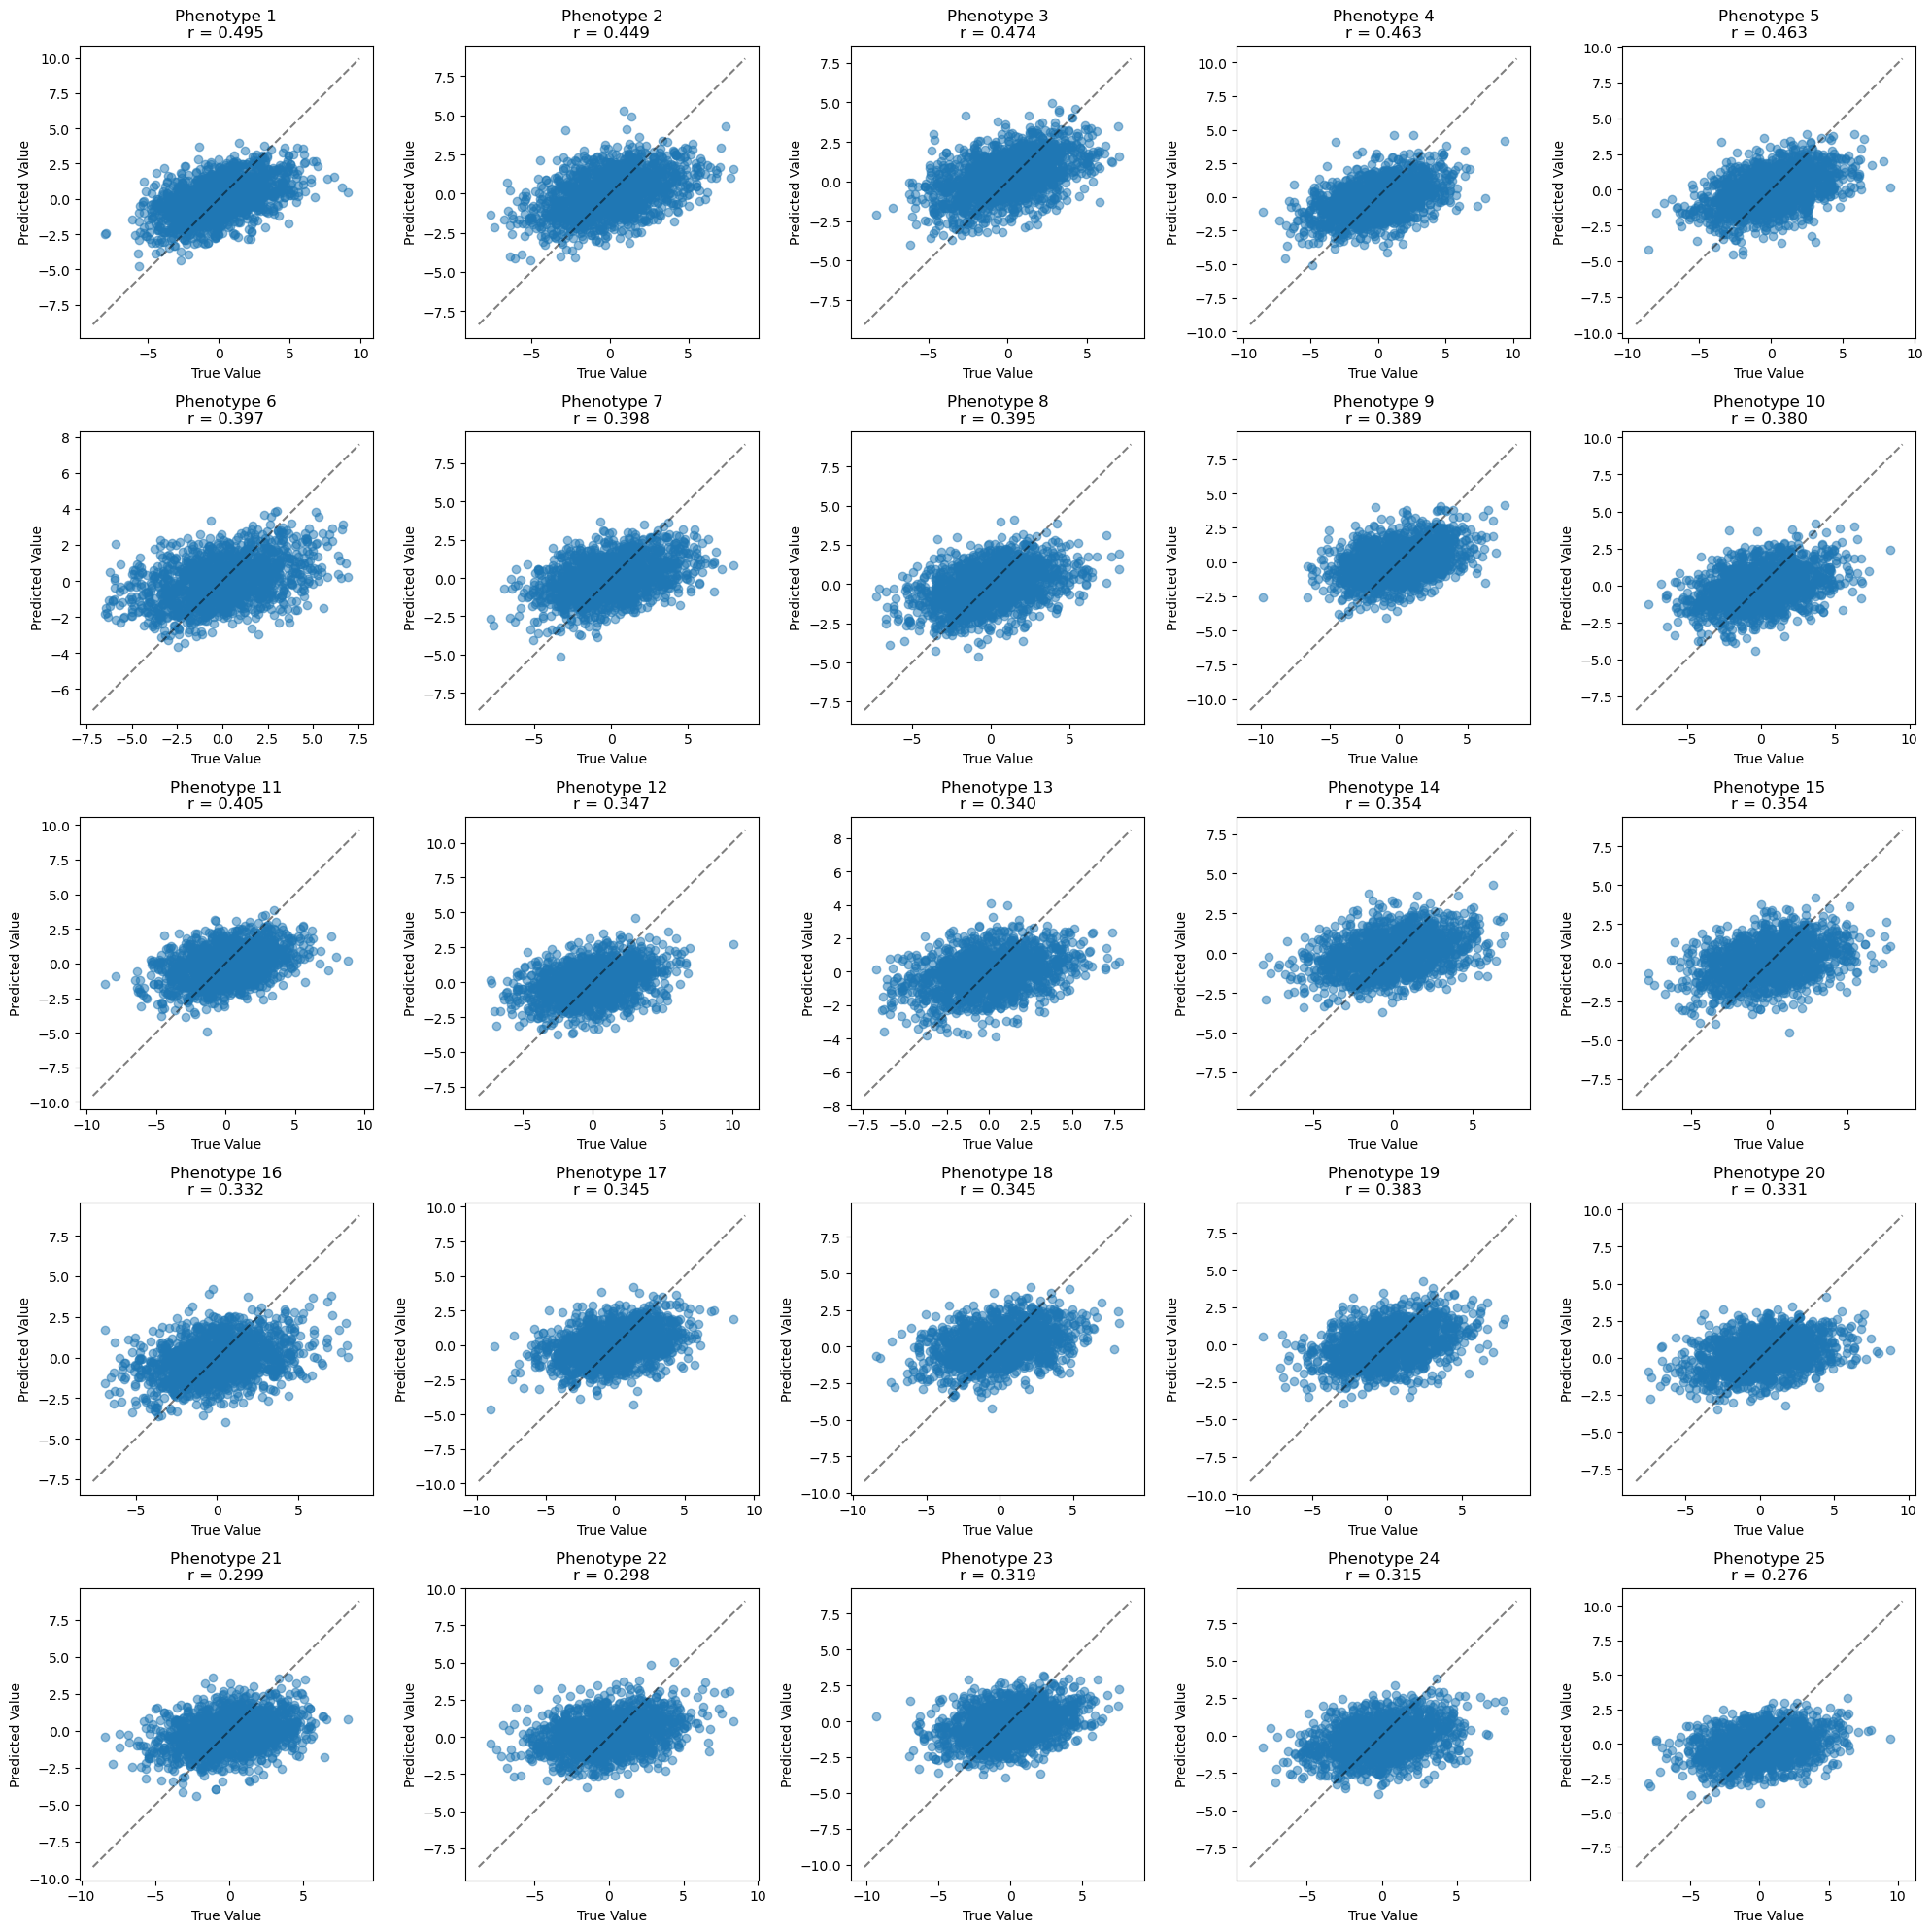

In [16]:

# Load GQ encoder
def load_pretrained_encoder(encoder_path, params):
    encoder = LDEncoder(
        input_length=params['input_length'],
        loci_count=params['loci_count'],
        window_size=params['window_size'],
        latent_dim=params['latent_space_g'],
        n_out_channels=params['n_out_channels'],
        window_stride=params.get('window_stride', 5)
    )

    # Load state dict
    state_dict = torch.load(encoder_path)
    encoder.load_state_dict(state_dict)

    return encoder

GQ = load_pretrained_encoder("localgg_enc_1kbt_V1_state_dict.pt", g_params)

GQ.to(device)
GQ.requires_grad_(False)  # freeze weights
GQ.eval()



# Load PP autoencoder
#pp_files = list(Path('optuna').glob(f''+file_prefix+'_pp_decoder.pt'))
pp_checkpoint = torch.load("localgg_P_1kbt_V1_state_dict.pt")  # Load the last (best) checkpoint

P = P_net(phen_dim=n_phen, N=latent_space_p).to(device)
P.load_state_dict(pp_checkpoint)
P.eval()

# Load GP network
gp_checkpoint = torch.load("localgg_GQP_1kbt_V1_state_dict.pt")  # Load the last (best) checkpoint


GQP = GQ_to_P_net(N=latent_space_p, latent_space_g=g_latent).to(device)
GQP.load_state_dict(gp_checkpoint)
GQP.eval()

# Collect predictions and true values
true_phenotypes = []
predicted_phenotypes = []

with torch.no_grad():
    for phens, gens in test_loader_gp:
        phens = phens.to(device)
        gens = gens.to(device)

        # Get predictions
        z_sample = GQ(gens)
        z_sample = GQP(z_sample)
        predictions = P(z_sample)

        # Store results
        true_phenotypes.append(phens.cpu().numpy())
        predicted_phenotypes.append(predictions.cpu().numpy())

# Concatenate batches
true_phenotypes = np.concatenate(true_phenotypes)
predicted_phenotypes = np.concatenate(predicted_phenotypes)

# Calculate correlations for each phenotype
correlations = []
p_values = []
for i in range(n_phen):
    corr, p_val = pearsonr(true_phenotypes[:, i], predicted_phenotypes[:, i])
    correlations.append(corr)
    p_values.append(p_val)

# Create plot
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.ravel()

for i in range(n_phen):
    ax = axes[i]
    ax.scatter(true_phenotypes[:, i], predicted_phenotypes[:, i], alpha=0.5)
    ax.set_title(f'Phenotype {i+1}\nr = {correlations[i]:.3f}')
    ax.set_xlabel('True Value')
    ax.set_ylabel('Predicted Value')

    # Add diagonal line
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1]),
    ]
    ax.plot(lims, lims, 'k--', alpha=0.5)

plt.tight_layout()


In [17]:
correlations

[0.49489182767662143,
 0.4485561205109016,
 0.4737501569683644,
 0.46263495111927,
 0.46262248444909204,
 0.3967469858845618,
 0.3984692082025134,
 0.3945448431374956,
 0.38867760763099213,
 0.3802600023381242,
 0.4046899825722372,
 0.34678457099693816,
 0.3400188169498861,
 0.3539528535129719,
 0.3539632526891765,
 0.3318909862990296,
 0.3446368090551175,
 0.3452640893560064,
 0.38281722884441294,
 0.330729326318135,
 0.2991023089022704,
 0.29817382119969693,
 0.31904230442793846,
 0.31473417368063394,
 0.275803792978877]

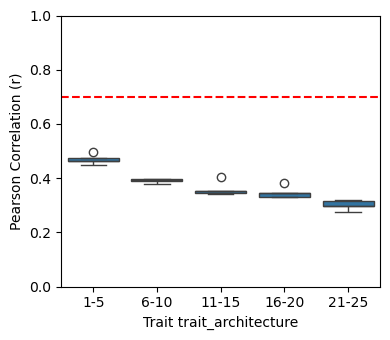

In [18]:
# After calculating correlations and p-values
# Create a grouped dataframe for Seaborn
import pandas as pd

# Create data for the boxplot
boxplot_data = []
for i in range(0, n_phen, 5):
    end_idx = min(i+5, n_phen)
    group_name = f"{i+1}-{end_idx}"
    for j in range(i, end_idx):
        boxplot_data.append({
            'trait_architecture': group_name,
            'pearson_corr': correlations[j],
            'trait_number': j+1
        })

# Convert to DataFrame
corr_df = pd.DataFrame(boxplot_data)

# Create the boxplot with Seaborn
plt.figure(figsize=(4, 3.5))

sns.boxplot(x="trait_architecture", y="pearson_corr", data=corr_df)


# Customize the plot
plt.ylabel('Pearson Correlation (r)')
plt.xlabel('Trait trait_architecture')
plt.ylim(0, 1)
plt.axhline(y=0.7, color='red', linestyle='--')


plt.tight_layout()
#plt.savefig(f'gpatlas/optuna/correlation_boxplot_{timestamp}.png')
#plt.close()